In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Tuple
from tqdm import tqdm

In [2]:
from typing import List, Tuple
import math


class SmartPlot:

    @staticmethod
    def plot_single_image(image, title, colorbar=False):
        plt.imshow(image)
        plt.title(title)
        if colorbar:
            plt.colorbar()
        plt.show()

    @staticmethod
    def get_dimensions(N):
        sqrt = round(math.sqrt(N))
        if sqrt * sqrt == N:
            return (sqrt, sqrt)
        for m in range(5, 0, -1):
            if N % m == 0:
                return (N // m, m)

    @classmethod
    def plot_multi_images(cls,
                          images: List,
                          figsize: Tuple[int, int],
                          titles: List | None = None,
                          axis: List | str = 'on',
                          cmaps: List | str = 'viridis',
                          suptitle: str | None = None,
                          dimensions: Tuple[int, int] | None = None,
                          colorbar: bool | List[bool] = False,
                          return_fig_axis: bool = False):
        num_images = len(images)
        if titles is None:
            titles = [None] * num_images
        if dimensions is None:
            dimensions = cls.get_dimensions(num_images)
        if type(colorbar) is bool:
            colorbar = [colorbar] * num_images
        if type(axis) is str:
            axis = [axis] * num_images
        if type(cmaps) is str:
            cmaps = [cmaps] * num_images

        fig, ax = plt.subplots(*dimensions, figsize=figsize)
        ax = np.array(ax).flatten()

        for i, (img, title, cbar) in enumerate(zip(images, titles, colorbar)):
            t = ax[i].imshow(img, cmap=cmaps[i])
            if title:
                ax[i].set_title(title)
            if cbar:
                plt.colorbar(t)
            ax[i].axis(axis[i])

        if suptitle:
            fig.suptitle(suptitle)
        if return_fig_axis:
            return fig, ax
        else:
            plt.show()

# Question-1

In [3]:
def patchify(img, block_size: Tuple = (8, 8)):
    """
    return n x m shaped array where n is the number of patches
    m is the flattened block size

    Args:
        img (_type_): the input image
        block_size (Tuple, optional): size of the block. Defaults to (8, 8).

    Returns:
        np.ndarray: the patchified array
    """
    k1, k2 = block_size
    n, m = img.shape
    if n % k1 != 0:
        temp_img = np.zeros((n + k1 - (n % k1), m))
        temp_img[:n, :m] = img
        img = temp_img

    n, m = img.shape  # might change n

    if m % k2 != 0:
        temp_img = np.zeros((n, m + k2 - (m % k2)))
        temp_img[:n, :m] = img
        img = temp_img

    n, m = img.shape
    out = []
    for x in range(0, n, k1):
        for y in range(0, m, k2):
            out.append(img[x:x + k1, y:y + k2].flatten())
    return np.array(out), img.shape


def unpatchify(arr, img_shape, block_size: Tuple = (8, 8)):
    n, m = arr.shape
    k1, k2 = block_size
    if m != k1 * k2:
        raise ValueError('The dimensions of the block don\'t match the array')
    img = np.zeros(img_shape)
    x, y = img_shape
    if y % k2 != 0:
        raise ValueError('The diemnsions of image are incorrect!')
    y //= k2
    for patch_idx in tqdm(range(n)):
        pos_x, pos_y = patch_idx // y, patch_idx % y
        img[pos_x * k1:(pos_x + 1) * k1,
            pos_y * k2:(pos_y + 1) * k2] = arr[patch_idx].reshape((k1, k2))
    return img


def pca(arr, out_dim):
    """
    Assumes the data is m x n
    where m is the number of feature
    n is the number of data points

    Args:
        arr (np.ndarray): the input array

    Returns:
        np.ndarray: decorrelated data
    """
    m, n = arr.shape
    if m < out_dim:
        raise ValueError(
            'Output dimension should be smaller than input feature dimensions')

    cov = arr @ arr.T
    evals, evecs = np.linalg.eigh(cov)
    evals = evals[::-1]
    evecs = evecs[:, ::-1]
    V = evecs[:, :out_dim]
    print(f'Lost fraction of variance: {evals[out_dim:].sum()/evals.sum()}')
    return V @ V.T @ arr


def gaussian_filter(sigma, filter_size):
    # we can write the gaussian filter as a gram matrix
    # this is because it can be separated as a function of
    # u and v
    vec = np.arange(-(filter_size - 1) / 2, (filter_size + 1) / 2)
    vec = np.exp(-0.5 * np.square(vec) / (sigma**2))

    filter = vec[:, None] @ vec[None, :]
    filter /= 2 * np.pi * np.square(sigma)
    filter /= filter.sum()
    return filter


class Image_quality_measures:

    @staticmethod
    def mse(image1: np.ndarray, image2: np.ndarray):
        return np.mean(np.square(image1 - image2))

    @classmethod
    def psnr(cls, image1: np.ndarray, image2: np.ndarray):
        return 10 * np.log10(255 * 255 / (cls.mse(image1, image2) + 1e-9))

    @staticmethod
    def ssim(image1, image2):
        C1 = (2.55)**2
        C2 = 9 * C1
        C3 = C2 / 2
        filter_size = 5
        f = filter_size
        sigma = (filter_size - 1) / 6
        window = gaussian_filter(sigma=sigma, filter_size=filter_size)
        n, m = image1.shape
        dummy_image1 = np.zeros((n + f, m + f))
        dummy_image2 = np.zeros((n + f, m + f))
        dummy_image1[f // 2:-f // 2, f // 2:-f // 2] = image1
        dummy_image2[f // 2:-f // 2, f // 2:-f // 2] = image2
        image1 = dummy_image1
        image2 = dummy_image2

        def luminance_similarity(patch1, patch2):
            u1 = np.sum(patch1 * window)
            u2 = np.sum(patch2 * window)
            return (2 * u1 * u2 + C1) / (u1 * u1 + u2 * u2 + C1)

        def weighted_std(patch):
            arr = patch - patch.mean()
            arr = arr * arr * window
            return np.sqrt(arr.sum())

        def contrast_similarity(patch1, patch2):
            sig1 = weighted_std(patch1)
            sig2 = weighted_std(patch2)
            return (2 * sig1 * sig2 + C2) / (sig1 * sig1 + sig2 * sig2 + C2)

        def weighted_cross_covariance(patch1, patch2):
            arr1 = patch1 - patch1.mean()
            arr2 = patch2 - patch2.mean()
            return np.sum(window * arr1 * arr2)

        def structure_similarity(patch1, patch2):
            sig1 = weighted_std(patch1)
            sig2 = weighted_std(patch2)
            sig12 = weighted_cross_covariance(patch1, patch2)
            return (sig12 + C3) / (sig1 * sig1 + sig2 * sig2 + C3)

        def ssim(i, j):
            patch1 = image1[i - f // 2:i + 1 + f // 2,
                            j - f // 2:j + 1 + f // 2]
            patch2 = image2[i - f // 2:i + 1 + f // 2,
                            j - f // 2:j + 1 + f // 2]
            return (luminance_similarity(patch1, patch2) *
                    contrast_similarity(patch1, patch2) *
                    structure_similarity(patch1, patch2))

        ssim_map = np.array(
            [[ssim(i, j) for j in range(f // 2, image1.shape[1] - f // 2 - 1)]
             for i in range(f // 2, image1.shape[0] - f // 2 - 1)])
        return ssim_map, ssim_map.mean()

Lost fraction of variance: 5.41663032825216e-05


100%|██████████| 7569/7569 [00:00<00:00, 246509.20it/s]

Lost fraction of variance: 0.00047200120746525065


100%|██████████| 7569/7569 [00:00<00:00, 242585.56it/s]


Lost fraction of variance: 0.0046902176039056755


100%|██████████| 7569/7569 [00:00<00:00, 240363.17it/s]


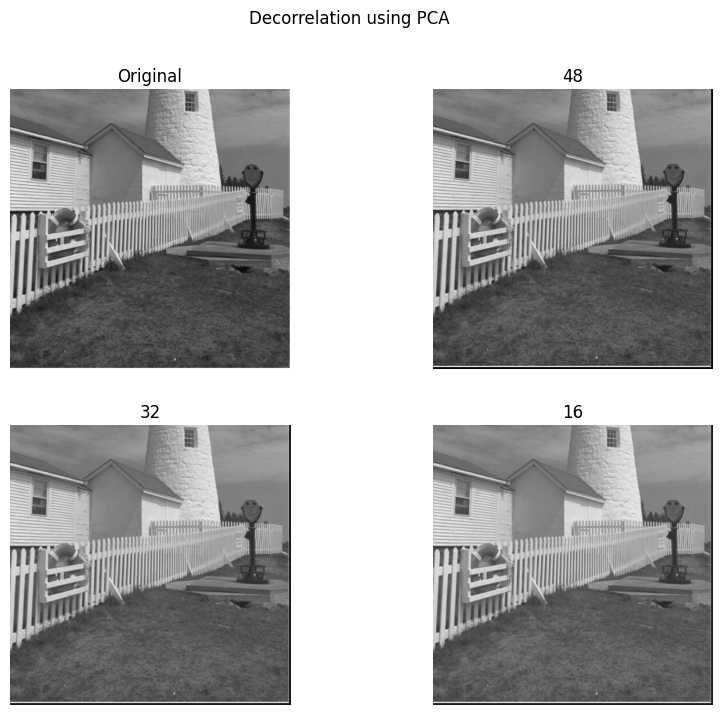

In [4]:
lighthouse = plt.imread('./lighthouse.png')[:, :, 0] * 255
lighthouse = lighthouse.astype(int)


patchified_lighthouse, patchified_lighthouse_shape = patchify(lighthouse)
mean_of_patch_arr = np.mean(patchified_lighthouse, axis=0)
patchified_lighthouse -= mean_of_patch_arr

# level 48
img_48_patchified = pca(patchified_lighthouse.T, 48).T
img_48_patchified += mean_of_patch_arr
img_48 = unpatchify(img_48_patchified, patchified_lighthouse_shape)

# level 32
img_32_patchified = pca(patchified_lighthouse.T, 32).T
img_32_patchified += mean_of_patch_arr
img_32 = unpatchify(img_32_patchified, patchified_lighthouse_shape)

# level 16
img_16_patchified = pca(patchified_lighthouse.T, 16).T
img_16_patchified += mean_of_patch_arr
img_16 = unpatchify(img_16_patchified, patchified_lighthouse_shape)

SmartPlot.plot_multi_images([lighthouse, img_48, img_32, img_16],
                            figsize=(10, 8),
                            titles=['Original', '48', '32', '16'],
                            axis='off',
                            cmaps='gray',
                            suptitle='Decorrelation using PCA')
plt.show()


The above method is good at decorrelation (linear), we can see that the amount of information represented by the later principal components is very small. This is an effective method but suffers from the dependence on image data to get the decorrelating transform (eigen vector matrix).

# Question-2

In [5]:
class DCT:
    Q_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                         [12, 12, 14, 19, 26, 58, 60, 55],
                         [14, 13, 16, 24, 40, 57, 69, 56],
                         [14, 17, 22, 29, 51, 87, 80, 62],
                         [18, 22, 37, 56, 68, 109, 103, 77],
                         [24, 35, 55, 64, 81, 104, 113, 92],
                         [49, 64, 78, 87, 103, 121, 120, 101],
                         [72, 92, 95, 98, 112, 100, 103, 99]])

    @staticmethod
    def dct(patch):
        c_vec = np.ones((8, 1)) # 2 axes necessary for gram matrix
        c_vec[0] = 1 / np.sqrt(2)
        prefix_matrix = c_vec @ c_vec.T / 16
        temp_vec1 = (2 * np.arange(8) + 1)[:, None]
        temp_vec2 = np.arange(8)[:, None]
        cos_matrix = np.cos(temp_vec1 @ temp_vec2.T * np.pi/ 16)
        inner_matrix = patch @ cos_matrix
        overall = cos_matrix.T @ inner_matrix
        return prefix_matrix * overall

    @classmethod
    def quantize(cls, dct):
        return (dct/cls.Q_matrix + 0.5).astype(int)

    @classmethod
    def dequantize(cls, dct):
        return dct * cls.Q_matrix

    @staticmethod
    def idct(patch):
        c_vec = np.ones(8)
        c_vec[0] = 1 / np.sqrt(2)
        temp_vec1 = (2 * np.arange(8) + 1)[:, None]
        temp_vec2 = np.arange(8)[:, None]
        cos_matrix = np.cos(temp_vec1 @ temp_vec2.T * np.pi/ 16)
        inner_matrix = patch @ np.diag(c_vec) @ cos_matrix.T
        overall = cos_matrix @ np.diag(c_vec) @ inner_matrix
        return overall
        

In [6]:
patches, img_shape = patchify(lighthouse)
patches = patches.reshape((patches.shape[0], 8, 8))
patches.shape

(7569, 8, 8)

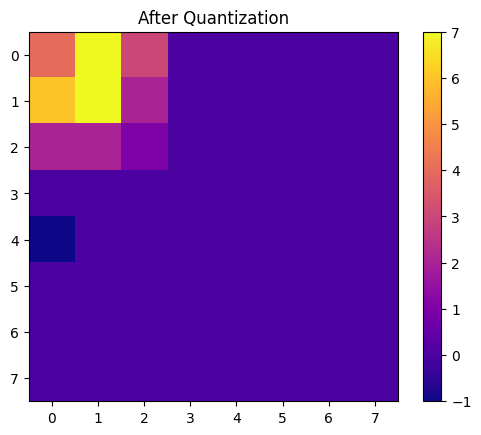

100%|██████████| 7569/7569 [00:00<00:00, 296119.61it/s]


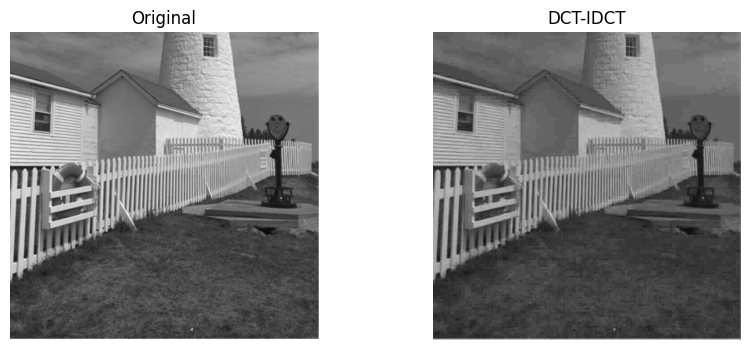

In [7]:
restored_patches = []

for patch in patches:
    patch_dct = DCT.dct(patch)
    quantized_patch = DCT.quantize(patch_dct)
    dequantized_patch = DCT.dequantize(quantized_patch)
    restored_patch = DCT.idct(dequantized_patch).flatten()
    restored_patches.append(restored_patch)

restored_patches = np.array(restored_patches)

plt.imshow(quantized_patch, cmap='plasma')
plt.title('After Quantization')
plt.colorbar()
plt.show()

restored_lighthouse = unpatchify(restored_patches, img_shape)
n, m = lighthouse.shape
restored_lighthouse = restored_lighthouse[:n, :m]
SmartPlot.plot_multi_images([lighthouse, restored_lighthouse],
                            titles=['Original', 'DCT-IDCT'],
                            figsize=(10, 4),
                            axis='off',
                            cmaps='gray')
plt.show()

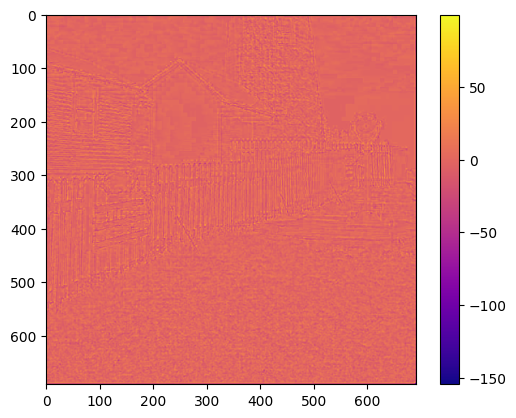

In [8]:
plt.imshow(restored_lighthouse-lighthouse, cmap='plasma')
plt.colorbar()
plt.show()

It can be observed that the after quantization we get a spare matrix.

In the above difference image we can see that quantization of dct coefficients removes the high frequency content from the image.

DCT is an effective method for image compression because most of the coefficient obtained after quantization are 0.

# Question-3

In [9]:
image_1 = plt.imread('./first_frame.png')
image_2 = plt.imread('./second_frame.png')
n, m = image_1.shape


In [10]:
def mean_absolute_distance(patch1, patch2):
    return np.mean(np.abs(patch1 - patch2))


def find_best_match(patch, reference_image, init_pos, level=2):
    x, y = init_pos
    div = 1 << level
    x_shifts = y_shifts = [-div, 0, div]
    
    n, m = reference_image.shape
    best_pos = init_pos
    min_dist = np.inf

    for dx in x_shifts:
        for dy in y_shifts:
            i, j = x + dx, y + dy
            if i < 0 or j < 0 or i+16 >= n or j+16 >= m:
                continue
            reference_patch = reference_image[i:i+16, j:j+16]
            dist = mean_absolute_distance(patch, reference_patch)
            if dist < min_dist:
                min_dist = dist
                best_pos = (i, j)
    if level == 0:
        return best_pos
    else:
        return find_best_match(patch, reference_image, best_pos, level-1)


In [11]:
# Color Palette
import seaborn as sns

palette = sns.color_palette("plasma", n_colors=25)
max_vec_size = 7 * np.sqrt(2)


class continuous_subscript(list):
    def __init__(self, palette, max_size):
        super().__init__(palette)
        self.max_size = max_size

    def __getitem__(self, key):
        key = np.round(key / self.max_size * (len(self)-1)).astype(int)
        return super().__getitem__(key)


palette = continuous_subscript(palette, max_vec_size)

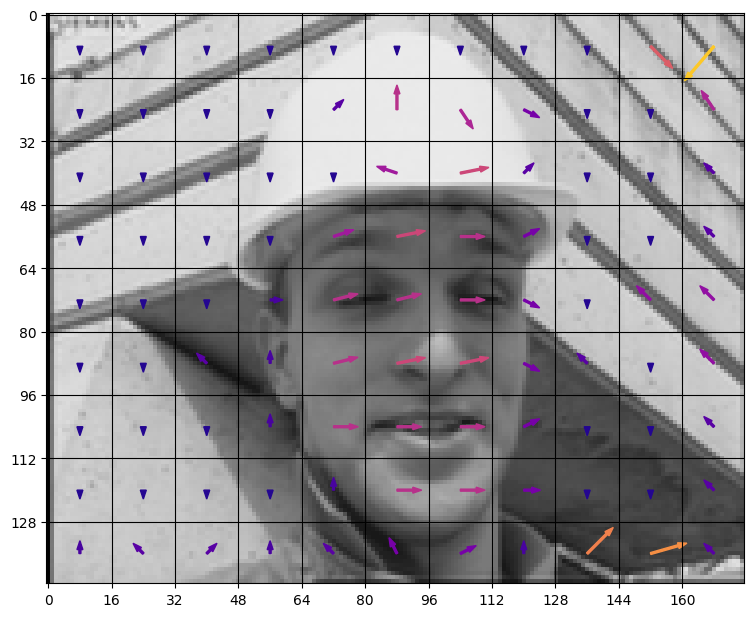

In [12]:
fig = plt.figure(figsize=(n // 15, m // 15))
plt.imshow(image_1, cmap='gray')
plt.grid(True, color='black')
plt.xticks(np.linspace(0, m, num=m // 16 + 1).astype(int))
plt.yticks(np.linspace(0, n, num=n // 16 + 1).astype(int))

new_img = image_1.copy()

for x in range(0, n, 16):
    for y in range(0, m, 16):
        patch = image_1[x:x + 16, y:y + 16]
        pos = find_best_match(patch, image_2, (x, y))
        new_img[pos[0]:pos[0] + 16, pos[1]:pos[1] + 16] = image_1[x:x + 16,
                                                                  y:y + 16]
        vec = (pos[0] - x, pos[1] - y)
        norm_vec = np.linalg.norm(vec)
        plt.arrow(y + 8,
                  x + 8,
                  vec[1],
                  vec[0],
                  color=palette[norm_vec],
                  width=0.5)


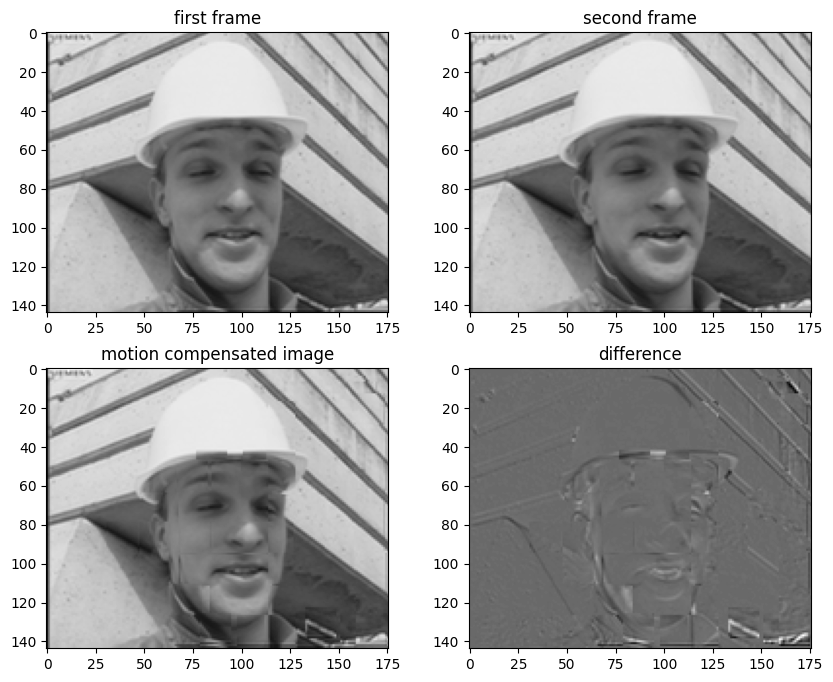

In [13]:
SmartPlot.plot_multi_images([image_1, image_2, new_img, new_img - image_2],
                            titles=[
                                'first frame', 'second frame',
                                'motion compensated image', 'difference'
                            ],
                            figsize=(10, 8), 
                            cmaps='gray')

In [14]:
print(f'Error: {mean_absolute_distance(image_2, new_img)}')

Error: 0.015125674195587635
